In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

# Load / process data

In [3]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (50000, 32, 32, 3)
X_test.shape:  (10000, 32, 32, 3)


In [4]:
## Create extra type feature (0 = vehicle, 1 = animal)
type_train = np.zeros_like(y_train)
type_train[(y_train == 0) | (y_train == 1) | (y_train == 8) | (y_train == 9)] = 1

type_test = np.zeros_like(y_test)
type_test[(y_test == 0) | (y_test == 1) | (y_test == 8) | (y_test == 9)] = 1

# Modeling

In [5]:
# -----------------------------------------------------------
# Build two-input CNN model
# -----------------------------------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

dropout_rate = 0.2
n_classes  = np.unique(y_train).shape[0]

# Image input and CNN
img_input = Input(shape=X_train.shape[1:], name="image_input")

x = Conv2D(8, (3, 3), activation='relu', padding='same')(img_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = GlobalAveragePooling2D()(x)

# Type input (scalar: 0 or 1)
type_input = Input(shape=(1,), name="type_input")

# Concatenate CNN features with type
concat = Concatenate()([x, type_input])

# Dense block
x = Dense(32, activation='relu')(concat)
x = Dropout(dropout_rate)(x)
x = Dense(16, activation='relu')(x)
output = Dense(n_classes, activation='softmax')(x)

# Final model
model = Model(inputs=[img_input, type_input], outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 8)         │             224 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 16, 16, 8)         │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 16, 16, 8)         │              32 │ max_pooling2d[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 16, 16, 8)         │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 16, 16, 16)        │           1,168 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 8, 8, 16)          │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 8, 8, 16)          │              64 │ max_pooling2d_1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 8, 8, 16)          │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 8, 8, 32)          │           4,640 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 4, 4, 32)          │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 4, 4, 32)          │             128 │ max_pooling2d_2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 4, 4, 32)          │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 4, 4, 64)          │          18,496 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 2, 2, 64)          │               

 Total params: 27,818 (108.66 KB)

 Trainable params: 27,578 (107.73 KB)

 Non-trainable params: 240 (960.00 B)

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

epochs = 25
batch_size = 1000
initial_learning_rate = 0.005

optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

## Train model

In [7]:
history = model.fit(
    [X_train, type_train], y_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=([X_test, type_test], y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.2317 - loss: 2.0538 - val_accuracy: 0.2635 - val_loss: 1.9534
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4286 - loss: 1.4941 - val_accuracy: 0.4423 - val_loss: 1.3958
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5256 - loss: 1.2044 - val_accuracy: 0.5320 - val_loss: 1.1913
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5698 - loss: 1.1108 - val_accuracy: 0.6186 - val_loss: 0.9729
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5974 - loss: 1.0410 - val_accuracy: 0.6511 - val_loss: 0.9116
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6104 - loss: 1.0078 - val_accuracy: 0.6108 - val_loss: 1.0008
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6245 - loss: 0.9699 - val_accuracy: 0.6267 - val_loss: 0.9812
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6406 - loss: 0.9490 - val_accuracy: 0.6735 - v

## Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


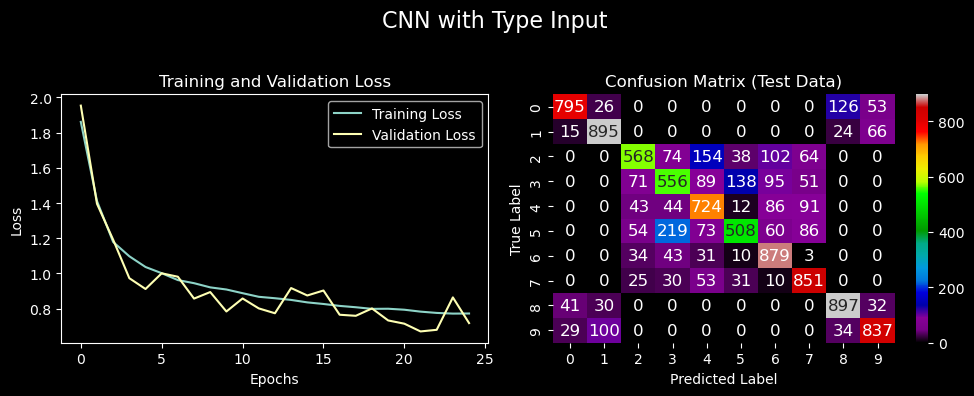

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1000
           1       0.85      0.90      0.87      1000
           2       0.71      0.57      0.63      1000
           3       0.58      0.56      0.57      1000
           4       0.64      0.72      0.68      1000
           5       0.69      0.51      0.58      1000
           6       0.71      0.88      0.79      1000
           7       0.74      0.85      0.79      1000
           8       0.83      0.90      0.86      1000
           9       0.85      0.84      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_test_pred = model.predict([X_test, type_test]).argmax(axis=1)

# Training plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('CNN with Type Input', fontsize=16)

# Left: loss curves
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right: confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0,
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_test_pred)
print(report)